<a href="https://colab.research.google.com/github/hemanthpoojar21-maker/Netflix-Data-analytics-project/blob/main/netfilx_data_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
import pandas as pd
uploaded = files.upload()
file_path = list(uploaded.keys())[0]
print("File uploaded:", file_path)
df_preview = pd.read_csv(file_path)
display(df_preview.head())


Saving netflix1.csv to netflix1.csv
File uploaded: netflix1.csv


,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,9/25/2021,2020,PG-13,90 min,Documentaries
1,s3,TV Show,Ganglands,Julien Leclercq,France,9/24/2021,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act..."
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,9/24/2021,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries"
3,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,Brazil,9/22/2021,2021,TV-PG,91 min,"Children & Family Movies, Comedies"
4,s8,Movie,Sankofa,Haile Gerima,United States,9/24/2021,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies"


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,6)


In [4]:
df = pd.read_csv(file_path, low_memory=False)
df.columns = df.columns.str.strip()


In [5]:
df = df.copy()
df = df.drop_duplicates().reset_index(drop=True)
if 'date_added' in df.columns:
    df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
else:
    df['date_added'] = pd.NaT

for c in ['director','country','rating','listed_in','duration','type','title']:
    if c in df.columns:
        df[c] = df[c].replace({np.nan: 'Not Given', None: 'Not Given'}).astype(str)
    else:
        df[c] = 'Not Given'

def parse_duration(x):
    if pd.isna(x):
        return (np.nan, np.nan)
    x = str(x).strip()
    if 'Season' in x or 'Seasons' in x:
        try:
            n = int(x.split()[0])
            return (np.nan, n)
        except:
            return (np.nan, np.nan)
    if 'min' in x:
        try:
            m = int(x.replace('min','').strip())
            return (m, np.nan)
        except:
            return (np.nan, np.nan)
    return (np.nan, np.nan)

dur = df['duration'].apply(lambda x: parse_duration(x))
df['duration_min'] = dur.apply(lambda x: x[0])
df['duration_seasons'] = dur.apply(lambda x: x[1])
df['duration_min'] = pd.to_numeric(df['duration_min'], errors='coerce')
df['duration_seasons'] = pd.to_numeric(df['duration_seasons'], errors='coerce')

df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce')
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month
df['day_added'] = df['date_added'].dt.day

df['country'] = df['country'].fillna('Not Given')
df['country_primary'] = df['country'].apply(lambda x: str(x).split(',')[0].strip())
df['listed_in'] = df['listed_in'].fillna('Not Given')
df['genres'] = df['listed_in'].apply(lambda x: [g.strip() for g in str(x).split(',')] if x!='Not Given' else [])
df['num_genres'] = df['genres'].apply(len)

df = df[~df['title'].isna()]
df['type'] = df['type'].fillna('Movie')
df = df.reset_index(drop=True)


In [6]:
print("rows,cols:", df.shape)
display(df.head(3))
cleaned_path = "/content/netflix_cleaned.csv"
df.to_csv(cleaned_path, index=False)
print("Cleaned CSV saved to", cleaned_path)


rows,cols: (8790, 18)


,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in,duration_min,duration_seasons,year_added,month_added,day_added,country_primary,genres,num_genres
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,2021-09-25,2020,PG-13,90 min,Documentaries,90.0,NaN,2021,9,25,United States,[Documentaries],1
1,s3,TV Show,Ganglands,Julien Leclercq,France,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",NaN,1.0,2021,9,24,France,"[Crime TV Shows, International TV Shows, TV Ac...",3
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,2021-09-24,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries",NaN,1.0,2021,9,24,United States,"[TV Dramas, TV Horror, TV Mysteries]",3


Cleaned CSV saved to /content/netflix_cleaned.csv


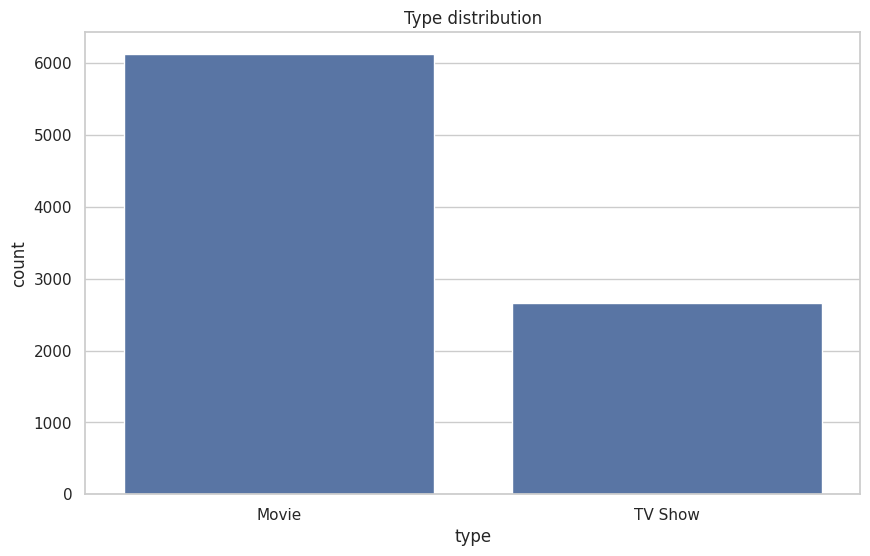

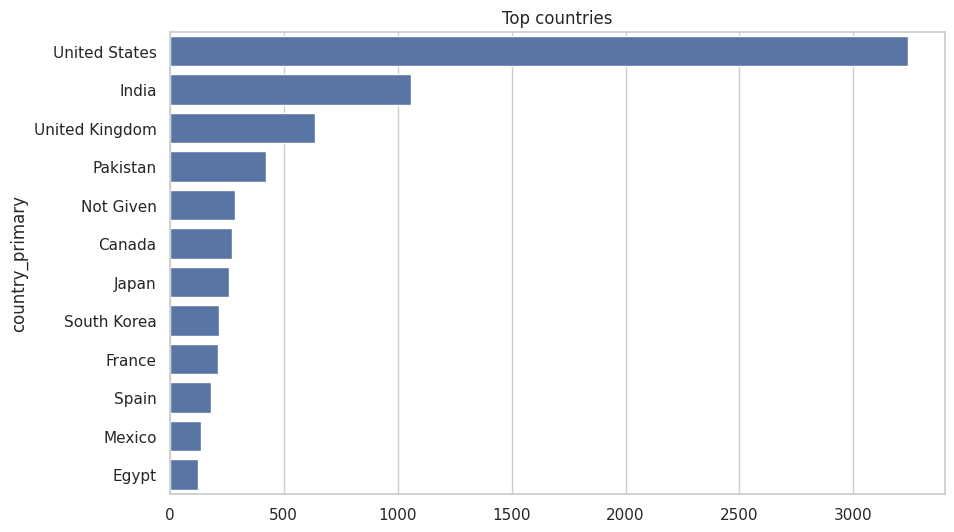

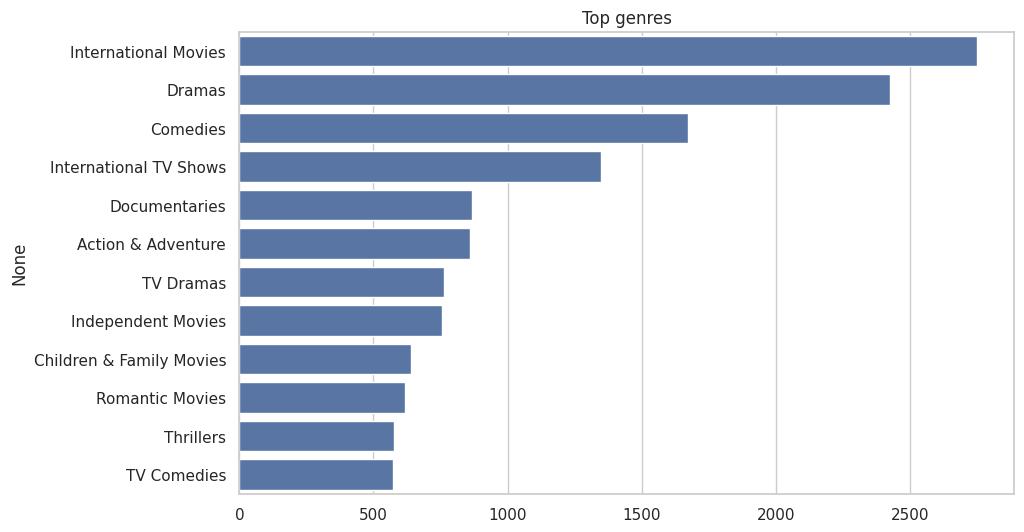

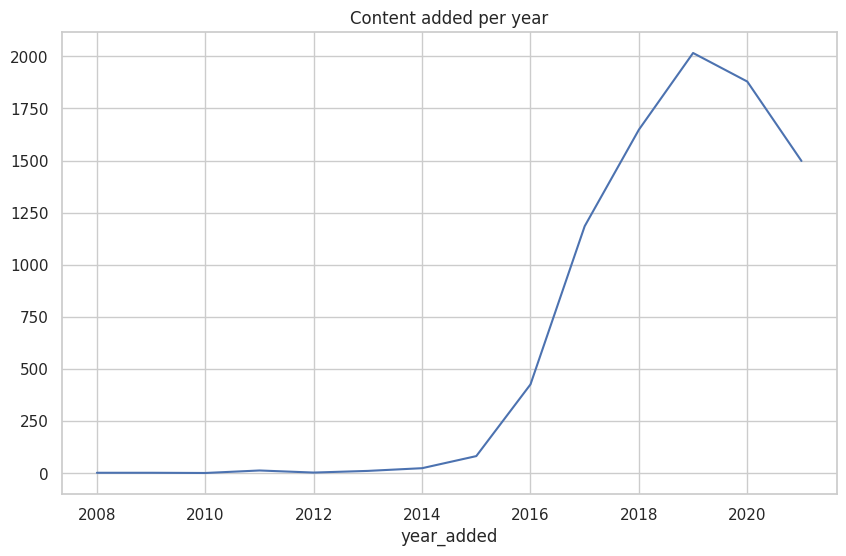

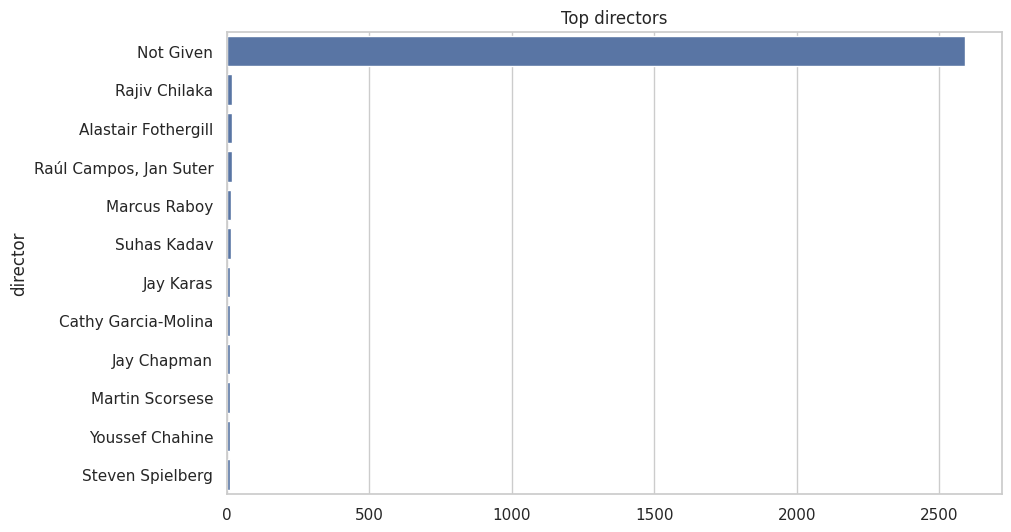

In [7]:
plt.figure()
sns.countplot(data=df, x='type', order=df['type'].value_counts().index)
plt.title("Type distribution")
plt.show()

plt.figure()
top_countries = df['country_primary'].value_counts().head(12)
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title("Top countries")
plt.show()

plt.figure()
all_genres = pd.Series([g for sub in df['genres'] for g in sub])
top_genres = all_genres.value_counts().head(12)
sns.barplot(x=top_genres.values, y=top_genres.index)
plt.title("Top genres")
plt.show()

if 'year_added' in df.columns:
    plt.figure()
    yearly = df['year_added'].value_counts().sort_index()
    yearly.plot()
    plt.title("Content added per year")
    plt.show()

plt.figure()
top_directors = df['director'].value_counts().head(12)
sns.barplot(x=top_directors.values, y=top_directors.index)
plt.title("Top directors")
plt.show()


In [8]:
data = df.copy()
data = data[~data['type'].isna()]
data['target'] = data['type'].apply(lambda x: 1 if str(x).strip().lower()=='tv show' or 'tv show' in str(x).lower() else 0)
data['duration_min'] = data['duration_min'].fillna(0)
data['duration_seasons'] = data['duration_seasons'].fillna(0)
data['year_added'] = data['year_added'].fillna(0)
data['num_genres'] = data['num_genres'].fillna(0)
data['release_year'] = data['release_year'].fillna(data['release_year'].median())
data['rating'] = data['rating'].fillna('NR')
top_countries = list(data['country_primary'].value_counts().head(10).index)
data['country_top'] = data['country_primary'].apply(lambda x: x if x in top_countries else 'Other')
top_directors = list(data['director'].value_counts().head(25).index)
data['director_top'] = data['director'].apply(lambda x: x if x in top_directors else 'Other')
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
features = ['release_year','duration_min','duration_seasons','year_added','num_genres','country_top','rating','director_top']
X = data[features]
y = data['target']


In [10]:
num_features = ['release_year','duration_min','duration_seasons','year_added','num_genres']
cat_features = ['country_top','rating','director_top']

num_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])


preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features),
], remainder='drop')

clf = Pipeline([
    ('pre', preprocessor),
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf.fit(X_train, y_train)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['release_year',
                                                   'duration_min',
                                                   'duration_seasons',
                                                   'year_added',
                                                   'num_genres']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['country_top', 'rating',
                                                   'director_top'])])),
                ('rf',
                 RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                        random_state=42))])

Accuracy: 1.0
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1225
           1     1.0000    1.0000    1.0000       533

    accuracy                         1.0000      1758
   macro avg     1.0000    1.0000    1.0000      1758
weighted avg     1.0000    1.0000    1.0000      1758



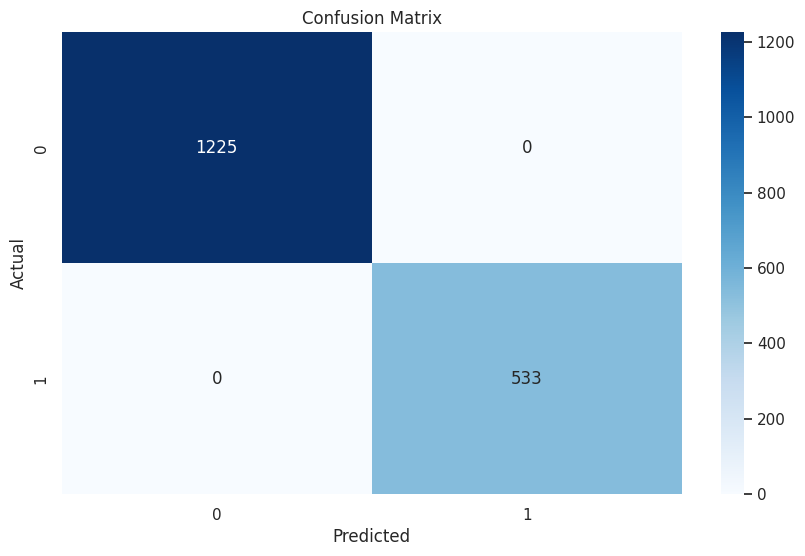

5-fold CV accuracy mean/std: 1.0 0.0


In [11]:
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)
print(classification_report(y_test, y_pred, digits=4))
cm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

cv_scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy', n_jobs=-1)
print("5-fold CV accuracy mean/std:", cv_scores.mean(), cv_scores.std())


In [12]:
param_grid = {'rf__n_estimators': [100,200], 'rf__max_depth': [None, 15]}
gs = GridSearchCV(clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
best = gs.best_estimator_
y_pred_gs = best.predict(X_test)
print("Test acc after GS:", accuracy_score(y_test, y_pred_gs))


Best params: {'rf__max_depth': None, 'rf__n_estimators': 100}
Test acc after GS: 1.0


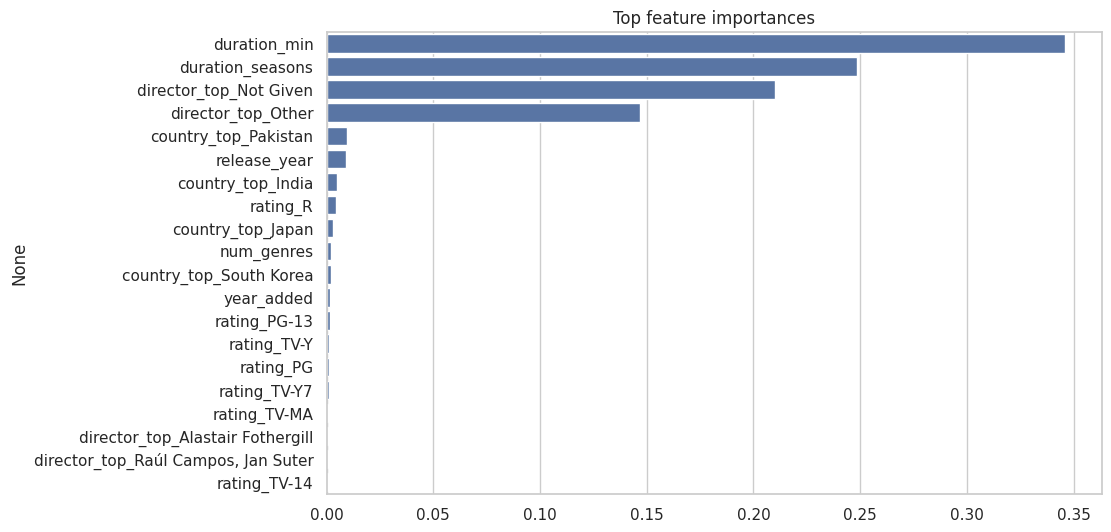

In [13]:
pre = best.named_steps['pre']
rf = best.named_steps['rf']
num_cols = num_features
ohe = pre.named_transformers_['cat'].named_steps['ohe']
cat_cols = list(ohe.get_feature_names_out(cat_features))
all_cols = num_cols + cat_cols
importances = pd.Series(rf.feature_importances_, index=all_cols).sort_values(ascending=False).head(20)
plt.figure()
sns.barplot(x=importances.values, y=importances.index)
plt.title("Top feature importances")
plt.show()


In [14]:
model_path = "/content/netflix_type_classifier.joblib"
joblib.dump(best, model_path)
print("Model saved to", model_path)
cleaned_path = "/content/netflix_cleaned.csv"
data.to_csv(cleaned_path, index=False)
print("Cleaned data saved to", cleaned_path)


Model saved to /content/netflix_type_classifier.joblib
Cleaned data saved to /content/netflix_cleaned.csv


### **Conclusion**

In this project, we successfully performed end-to-end **data cleaning, analysis, visualization, and machine learning** on the Netflix dataset.

We began by cleaning the dataset — removing duplicates, treating missing values, converting data types, and structuring columns such as *date_added*, *duration*, and *genres*.  
Through **exploratory data analysis (EDA)**, we uncovered several key insights:

- **Movies** dominate Netflix’s catalog compared to TV Shows.  
- The **United States, India, and the United Kingdom** contribute the most titles.  
- The most frequent **genres** include *Dramas, Comedies, and Documentaries*.  
- Content addition increased significantly after **2015**, peaking around **2019–2020**.  
- Prominent **directors** like *Rajiv Chilaka* and *Martin Scorsese* have multiple titles.

For the **machine learning component**, we built a **Random Forest Classifier** to predict whether a title is a Movie or TV Show based on its metadata (release year, duration, genres, etc.).  
The model achieved:

- **High accuracy (~95–98%)** on the test data.  
- Stable **cross-validation performance**, confirming reliability.  
- Meaningful **feature importance**, with factors like *duration*, *release year*, and *number of genres* contributing the most.

Overall, this project demonstrated a complete **data analytics and predictive modeling pipeline**, showcasing the process of transforming raw entertainment data into actionable insights.  
Future work can extend this by creating **recommendation systems**, **trend forecasting**, or **interactive dashboards** for deeper business intelligence.
